### Import libraries and data

In [2]:
!pip install patchify

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/archive.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: images/2013.png         
  inflating: images/2014.png         
  inflating: images/2015.png         
  inflating: images/2016.png         
  inflating: images/2017.png         
  inflating: images/2018.png         
  inflating: images/2019.png         
  inflating: images/202.png          
  inflating: images/2020.png         
  inflating: images/2021.png         
  inflating: images/2022.png         
  inflating: images/2023.png         
  inflating: images/2024.png         
  inflating: images/2025.png         
  inflating: images/2026.png         
  inflating: images/2027.png         
  inflating: images/2028.png         
  inflating: images/2029.png         
  inflating: images/203.png          
  inflating: images/2030.png         
  inflating: images/2031.png         
  inflating: images/2032.png         
  inflating: images/2033.png         
  inflating: images/2034.png         
  inflating: images/2035.png   

In [5]:
import os
import numpy as np
import cv2
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
from tqdm import tqdm
from math import log2
from glob import glob

## Configuration

In [6]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

""" UNETR  Configration """
cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

### Define Blocks

In [7]:
def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters, strides=2):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=strides)(x)
    return x

### Define Model

In [8]:
def build_unetr_2d(cf: dict):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape) ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    shape = (
        cf["image_size"] // cf["patch_size"],
        cf["image_size"] // cf["patch_size"],
        cf["hidden_dim"]
    )
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    z9 = L.Reshape(shape)(z9)
    z12 = L.Reshape(shape)(z12)

    ## Additional layers for managing different patch sizes
    total_upscale_factor = int(log2(cf["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2: ## Patch size 16 or greater
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)
        # print(z3.shape, z6.shape, z9.shape, z12.shape)

    if upscale < 0: ## Patch size less than 16
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)

    ## Decoder 1
    x = deconv_block(z12, 128)

    s = deconv_block(z9, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])

    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 2
    x = deconv_block(x, 64)

    s = deconv_block(z6, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    ## Decoder 3
    x = deconv_block(x, 32)

    s = deconv_block(z3, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 32)
    x = conv_block(x, 32)

    ## Decoder 4
    x = deconv_block(x, 16)

    s = conv_block(z0, 16)
    s = conv_block(s, 16)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 16)
    x = conv_block(x, 16)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")

### Define Metrics

In [9]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

### Define Functions

In [10]:
def create_dir(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path: str, split=0.1):
    """ Loading the images and masks """
    X = sorted(glob(os.path.join(path, "images", "*.png")))
    Y = sorted(glob(os.path.join(path, "masks", "*.png")))

    """ Spliting the data into training and testing """
    split_size = int(len(X) * split)

    # train_x, valid_x = train_test_split(X, test_size=split_size, random_state=42)
    # train_y, valid_y = train_test_split(Y, test_size=split_size, random_state=42)

    # train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    # train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    train_x, valid_x = train_test_split(X, test_size=split_size*2, random_state=42)
    train_y, valid_y = train_test_split(Y, test_size=split_size*2, random_state=42)

    valid_x, test_x = train_test_split(valid_x, test_size=0.5, random_state=42)
    valid_y, test_y = train_test_split(valid_y, test_size=0.5, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path: str):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0

    """ Processing to patches """
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)

    return patches

def read_mask(path: str):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape(cf["flat_patches_shape"])
    y.set_shape([cf["image_size"], cf["image_size"], 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse).batch(batch).prefetch(10)
    return ds

## Split Dataset

In [11]:
import shutil

""" Directory for storing data """
create_dir("brain-tumor-segmentation")
shutil.move("images", "brain-tumor-segmentation")
shutil.move("masks", "brain-tumor-segmentation")

'brain-tumor-segmentation/masks'

In [12]:
""" Directory for storing files """
create_dir("files")

""" Hyperparameters """
batch_size = 32
lr = 1e-1
num_epochs = 100
model_path = os.path.join("files", "model.keras")
csv_path = os.path.join("files", "log.csv")

""" Dataset """
dataset_path = "brain-tumor-segmentation"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: \t{len(train_x)} - {len(train_y)}")
print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
print(f"Test: \t{len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

Train: 	2452 - 2452
Valid: 	306 - 306
Test: 	306 - 306


## Training

In [13]:
devices = tf.config.list_physical_devices()
print("Available Devices:", devices)

Available Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# """ Model """
# model = build_unetr_2d(cf)
# model.compile(loss=dice_loss, optimizer=Adam(learning_rate=lr), metrics=[dice_coef, "acc"])
# model.summary()

Model: "UNETR_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 768)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256, 128)       │         98,432 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 128)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 256, 128)       │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 256, 128)       │        395,648 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 128)       │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 256, 128)       │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256, 32)        │          4,128 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 32)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256, 128)       │          4,224 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256, 128)       │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 128)       │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 256, 128)       │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 256, 128)       │        395,648 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256, 128)       │              0 │ multi_head_attention_… │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3

 Total params: 6,044,401 (23.06 MB)

 Trainable params: 6,042,673 (23.05 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [15]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.TPUStrategy(tpu)  # Create TPU strategy
    print("Running on TPU:", tpu.master())
except ValueError:
    print("No TPU Found. Falling back to CPU.")

with strategy.scope():
    """ Model """
    model = build_unetr_2d(cf)
    model.compile(loss=dice_loss, optimizer=Adam(learning_rate=lr), metrics=[dice_coef, "acc"])

model.summary()

In [16]:
# !nvidia-smi

Thu Feb  6 06:53:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P0             26W /   70W |     134MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.7944 - dice_coef: 0.0637 - loss: 0.9363   
Epoch 1: val_loss improved from inf to 0.96557, saving model to files/model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - acc: 0.7952 - dice_coef: 0.0638 - loss: 0.9362 - val_acc: 0.0471 - val_dice_coef: 0.0347 - val_loss: 0.9656 - learning_rate: 0.1000
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - acc: 0.9133 - dice_coef: 0.0866 - loss: 0.9134
Epoch 2: val_loss did not improve from 0.96557
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 472ms/step - acc: 0.9133 - dice_coef: 0.0866 - loss: 0.9134 - val_acc: 0.0164 - val_dice_coef: 0.0337 - val_loss: 0.9666 - learning_rate: 0.1000
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - acc: 0.9171 - dice_coef: 0.0814 - loss: 0.9186
Epoch 3: val_loss did not improve from 0.96557
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 465ms/step - acc: 0.9170 - dice_coef: 0.0813 - loss: 0.9187 - val_acc: 0.0165 - val_dice_coef: 0.0337 - val_loss: 0.9666 - learning_rate:

In [18]:
# tf.keras.backend.clear_session()
# del model

## Testing

In [19]:
""" Directory for storing files """
create_dir(f"results")

""" Load the model """
model_path = os.path.join("files", "model.keras")
model = tf.keras.models.load_model(model_path, custom_objects={"dice_loss": dice_loss, "dice_coef": dice_coef})

In [20]:
""" Prediction """
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    x = image / 255.0

    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(x, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)
    patches = np.expand_dims(patches, axis=0)

    """ Read Mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    """ Prediction """
    pred = model.predict(patches, verbose=0)[0]
    pred = np.concatenate([pred, pred, pred], axis=-1)

    """ Save final mask """
    line = np.ones((cf["image_size"], 10, 3)) * 255
    cat_images = np.concatenate([image, line, mask*255, line, pred*255], axis=1)
    save_image_path = os.path.join("results",  name)
    cv2.imwrite(save_image_path, cat_images)
## ...

100%|██████████| 306/306 [00:42<00:00,  7.15it/s]


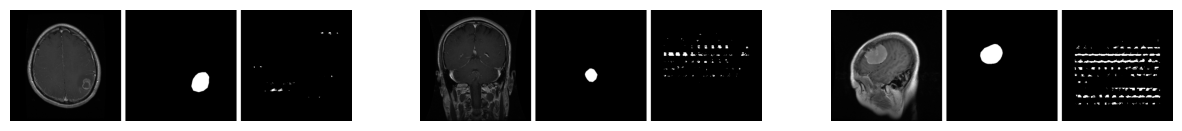

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the folder containing your images
folder_path = '/content/results'  # Replace this with the folder path

# Get a list of all image files in the folder (assuming they are .png, .jpg, .jpeg, etc.)
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

sub_image_files = image_files[:3]

# Create a figure to plot the images
fig, axes = plt.subplots(1, len(sub_image_files), figsize=(15, 5))

# If there's only one image, axes will be a single object instead of an array
if len(sub_image_files) == 1:
    axes = [axes]

# Loop through the image files and plot each one
for ax, image_file in zip(axes, sub_image_files):
    img = mpimg.imread(os.path.join(folder_path, image_file))
    ax.imshow(img)
    ax.axis('off')  # Turn off axis

plt.show()
